In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-colorblind')
import scipy.stats as sps
import networkx as nx
import time
from Dist_KL_UCB import Dist_KL_UCB
from Dist_UCB1 import Dist_UCB1
import os
from multiprocess import Pool

n_runs = 30
T = 10000
N = 20
rwd_means = [.2, .3, .4, .5, .6]

seeds = []
myseed = 0
while len(seeds) < n_runs:
    G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=myseed)
    if nx.is_connected(G):
        seeds.append(myseed)
    myseed += 1

sd = 0.1
distributions = [[sps.beta(rwd_means[i], 1-rwd_means[i]) for i in range(len(rwd_means))] for n in range(N)]
for n in range(N):
    for i in range(len(rwd_means)):
        distributions[n][i].random_state = np.random.RandomState(seed=1)
sigmas = [1, .1, .01]

In [3]:
def worker(job_runs, seeds, sigmas, T, N, distributions):
    mean_regrets_dist_kl_ucb = np.zeros((len(job_runs), len(sigmas), T))
    #mean_regrets_dist_ucb1 = np.zeros((len(job_runs), len(sigmas), T))
    for run in job_runs:
        start_run_t = time.time()
        G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=seeds[run])
        nodes = list(G.nodes)
        for i in nodes:
            G.add_edge(i,i) 
        for sig in range(len(sigmas)):
            distkl = Dist_KL_UCB(T, distributions, G, sigma=sigmas[sig])
            distkl.run()
            mean_regrets_dist_kl_ucb[run - job_runs[0], sig, :] = np.mean(distkl.regrets, axis=0)
            #distucb1 = Dist_UCB1(T, distributions, G, beta=sigmas[sig])
            #distucb1.run()
            #mean_regrets_dist_ucb1[run - job_runs[0], sig, :] = np.mean(distucb1.regrets, axis=0)
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return mean_regrets_dist_kl_ucb#, mean_regrets_dist_ucb1


In [ ]:
def worker_ucb1(job_runs, seeds, sigmas, T, N, distributions):
    mean_regrets_dist_ucb1 = np.zeros((len(job_runs), len(sigmas), T))
    for run in job_runs:
        start_run_t = time.time()
        G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=seeds[run])
        nodes = list(G.nodes)
        for i in nodes:
            G.add_edge(i,i) 
        for sig in range(len(sigmas)):
            distucb1 = Dist_UCB1(T, distributions, G, beta=sigmas[sig])
            distucb1.run()
            mean_regrets_dist_ucb1[run - job_runs[0], sig, :] = np.mean(distucb1.regrets, axis=0)
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return mean_regrets_dist_ucb1


In [4]:
mean_regrets_dist_kl_ucb = np.zeros((n_runs, len(sigmas), T))
#mean_regrets_dist_ucb1 = np.zeros((n_runs, len(sigmas), T))
cpus = os.cpu_count()
init_time = time.time()

pool = Pool() # no need to pass in cpus, does os.cpu_count() by default
jobs = list(range(n_runs))
job_size = max(n_runs // cpus, 1)
job_chunks = [(jobs[i:i + job_size], seeds, sigmas, T, N, distributions) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker, job_chunks)
pool.close()
pool.join()
mean_regrets_dist_kl_ucb_unconcat = [result for result in results]
#mean_regrets_dist_kl_ucb_unconcat = [result[0] for result in results]
#mean_regrets_dist_ucb1_unconcat = [result[1] for result in results]
np.concatenate(mean_regrets_dist_kl_ucb_unconcat, out=mean_regrets_dist_kl_ucb)
#np.concatenate(mean_regrets_dist_ucb1_unconcat, out=mean_regrets_dist_ucb1)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_kl_ucb = np.mean(mean_regrets_dist_kl_ucb, axis=0)
std_regrets_over_all_runs_dist_kl_ucb = np.std(mean_regrets_dist_kl_ucb, axis=0)
#mean_regrets_over_all_runs_dist_ucb1 = np.mean(mean_regrets_dist_ucb1, axis=0)
#std_regrets_over_all_runs_dist_ucb1 = np.std(mean_regrets_dist_ucb1, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_KL_UCB.py:179: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_KL_UCB.py:179: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)


finished run 15 in 479.487676858902sec
finished run 0 in 499.3110020160675sec
finished run 1 in 410.30015873908997sec
finished run 16 in 526.086891412735sec
finished run 17 in 309.7865455150604sec
finished run 2 in 431.7079532146454sec
finished run 3 in 458.6528458595276sec
finished run 18 in 500.18701219558716sec
finished run 4 in 585.7801852226257sec
finished run 19 in 719.4400088787079sec
finished run 5 in 436.02642822265625sec
finished run 20 in 365.3245060443878sec
finished run 6 in 367.176682472229sec
finished run 21 in 416.0641038417816sec
finished run 7 in 391.5384690761566sec
finished run 22 in 328.33977580070496sec
finished run 23 in 377.6589949131012sec
finished run 8 in 527.7457206249237sec
finished run 24 in 354.9205276966095sec
finished run 9 in 468.716105222702sec
finished run 25 in 524.7605538368225sec
finished run 10 in 368.6256031990051sec
finished run 26 in 406.2294204235077sec
finished run 11 in 366.6602153778076sec
finished run 12 in 479.76698780059814sec
finished 

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
linestyles = ['-', '--']
ax1.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[0], linestyles[0], label=r"$\varsigma=$" + str(sigmas[0]))
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[0]-std_regrets_over_all_runs_dist_kl_ucb[0], mean_regrets_over_all_runs_dist_kl_ucb[0]+std_regrets_over_all_runs_dist_kl_ucb[0],alpha=.2)
ax1.legend()
ax1.grid()
ax1.set_xlabel("Time")
ax1.set_ylabel("Regret")

ax2.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[1], linestyles[0], label=r"$\varsigma=$" + str(sigmas[1]))
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[1]-std_regrets_over_all_runs_dist_kl_ucb[1], mean_regrets_over_all_runs_dist_kl_ucb[1]+std_regrets_over_all_runs_dist_kl_ucb[1],alpha=.2)
ax2.legend()
ax2.grid()
ax2.set_xlabel("Time")

ax3.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[2], linestyles[0], label=r"$\varsigma=$" + str(sigmas[2]))
ax3.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[2]-std_regrets_over_all_runs_dist_kl_ucb[2], mean_regrets_over_all_runs_dist_kl_ucb[2]+std_regrets_over_all_runs_dist_kl_ucb[2],alpha=.2)
ax3.legend()
ax3.grid()
ax3.set_xlabel("Time")

#plt.savefig("dist_KL_vs_dist_UCB1_3subplots.pdf", bbox_inches='tight')

In [ ]:
mean_regrets_dist_ucb1 = np.zeros((n_runs, len(sigmas), T))
cpus = os.cpu_count()
init_time = time.time()

pool = Pool() # no need to pass in cpus, does os.cpu_count() by default
jobs = list(range(n_runs))
job_size = max(n_runs // cpus, 1)
job_chunks = [(jobs[i:i + job_size], seeds, sigmas, T, N, distributions) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker, job_chunks)
pool.close()
pool.join()
mean_regrets_dist_ucb1_unconcat = [result for result in results]
np.concatenate(mean_regrets_dist_ucb1_unconcat, out=mean_regrets_dist_ucb1)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_ucb1 = np.mean(mean_regrets_dist_ucb1, axis=0)
std_regrets_over_all_runs_dist_ucb1 = np.std(mean_regrets_dist_ucb1, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

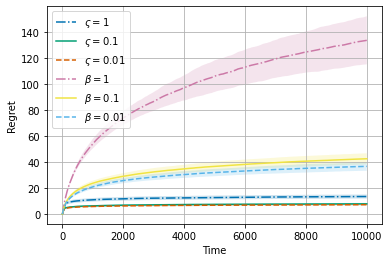

In [4]:
#linestyles = ['-.', '-', '--']
#for sig in range(len(sigmas)):
#    plt.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig], linestyles[sig], label=r"$\varsigma=$" + str(sigmas[sig]))
#    plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig]-std_regrets_over_all_runs_dist_kl_ucb[sig], mean_regrets_over_all_runs_dist_kl_ucb[sig]+std_regrets_over_all_runs_dist_kl_ucb[sig],alpha=.2)
#for sig in range(len(sigmas)):    
#    plt.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[sig], linestyles[sig], label=r"$\beta=$" + str(sigmas[sig]))
#    plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[sig]-std_regrets_over_all_runs_dist_ucb1[sig], mean_regrets_over_all_runs_dist_ucb1[sig]+std_regrets_over_all_runs_dist_ucb1[sig],alpha=.2)
#plt.xlabel("Time")
#plt.ylabel("Regret")
#plt.legend()
#plt.grid()
#plt.savefig("dist_KL_vs_dist_UCB1.pdf", bbox_inches='tight')

Text(0.5, 0, 'Time')

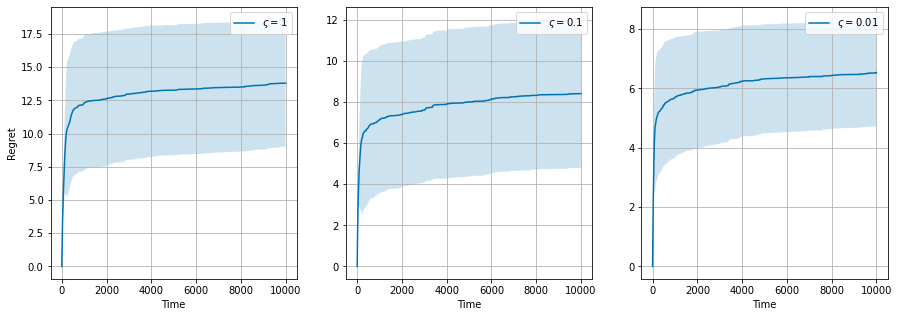

In [5]:
ax1.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[0], linestyles[1], label=r"$\beta=$" + str(sigmas[0]))
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[0]-std_regrets_over_all_runs_dist_ucb1[0], mean_regrets_over_all_runs_dist_ucb1[0]+std_regrets_over_all_runs_dist_ucb1[0],alpha=.2)

ax2.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[1], linestyles[1], label=r"$\beta=$" + str(sigmas[1]))
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[1]-std_regrets_over_all_runs_dist_ucb1[1], mean_regrets_over_all_runs_dist_ucb1[1]+std_regrets_over_all_runs_dist_ucb1[1],alpha=.2)

ax3.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[2], linestyles[1], label=r"$\beta=$" + str(sigmas[2]))
ax3.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[2]-std_regrets_over_all_runs_dist_ucb1[2], mean_regrets_over_all_runs_dist_ucb1[2]+std_regrets_over_all_runs_dist_ucb1[2],alpha=.2)

plt.savefig("dist_KL_vs_dist_UCB1_3subplots_fixed.pdf", bbox_inches='tight')